In [ ]:
import os
import cv2
import math
import time
import gdown
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
SEED_CONSTANT = 0
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

In [ ]:
DATASET = 'all-videos'
DATASET_ZIP = DATASET + '.zip'

if not os.path.exists(f'./{DATASET}') and not os.path.exists(f'./{DATASET_ZIP}'):
    download_link = 'https://drive.google.com/u/0/uc?id=1mMRiPk_7lPw2J0gMQdWBy3caRPFFUXWQ&export=download'
    gdown.download(download_link, DATASET_ZIP, quiet=False)

if not os.path.exists(f'./{DATASET}'):
    !unzip $DATASET_ZIP

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

SEQUENCE_LENGTH = 60

CLASSES_LIST = ["ArmFlapping", "HeadBanging"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ArmFlapping
Extracting Data of Class: HeadBanging


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25,
    shuffle = True, random_state = SEED_CONSTANT
)

In [ ]:
def create_convlstm_model():
    model = Sequential()

    model.add(
        ConvLSTM2D(
            filters = 4, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True,
            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
        )
    )

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 8, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 14, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 16, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 60, 126, 126, 4)  1024      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 60, 63, 63, 4)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 60, 61, 61, 8)    3488      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 60, 31, 31, 8)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_14 (ConvLSTM2D)  (None, 60, 29, 29, 14)   11144     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 60, 15, 15, 14)  

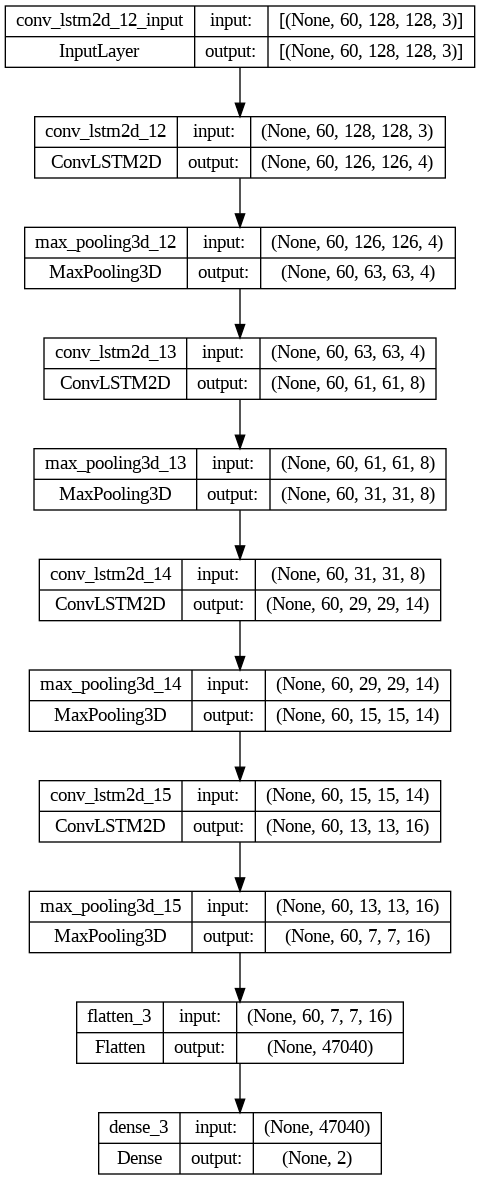

In [ ]:
plot_model(
    convlstm_model, to_file = 'convlstm_model_structure_plot.png',
    show_shapes = True, show_layer_names = True
)

In [ ]:
convlstm_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ["accuracy"]
)

convlstm_model_training_history = convlstm_model.fit(
    x = features_train, y = labels_train, epochs = 10,
    batch_size = 4,shuffle = True, validation_split = 0.25
)

Epoch 1/10
3/3 [==============================] - 95s 27s/step - loss: 1.5099 - accuracy: 0.6364 - val_loss: 0.5549 - val_accuracy: 0.7500
Epoch 2/10
3/3 [==============================] - 79s 27s/step - loss: 0.7774 - accuracy: 0.3636 - val_loss: 0.6782 - val_accuracy: 0.7500
Epoch 3/10
3/3 [==============================] - 79s 26s/step - loss: 0.6031 - accuracy: 0.8182 - val_loss: 0.5366 - val_accuracy: 0.7500
Epoch 4/10
3/3 [==============================] - 80s 28s/step - loss: 0.5806 - accuracy: 0.6364 - val_loss: 0.4617 - val_accuracy: 0.7500
Epoch 5/10
3/3 [==============================] - 80s 27s/step - loss: 0.6114 - accuracy: 0.5455 - val_loss: 0.4837 - val_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 81s 28s/step - loss: 0.3215 - accuracy: 0.9091 - val_loss: 0.3796 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 80s 28s/step - loss: 0.2199 - accuracy: 0.9091 - val_loss: 0.1971 - val_accuracy: 1.0000
Epoch 8/10
3/3 [===========

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 12s 12s/step - loss: 1.3117 - accuracy: 0.8333


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

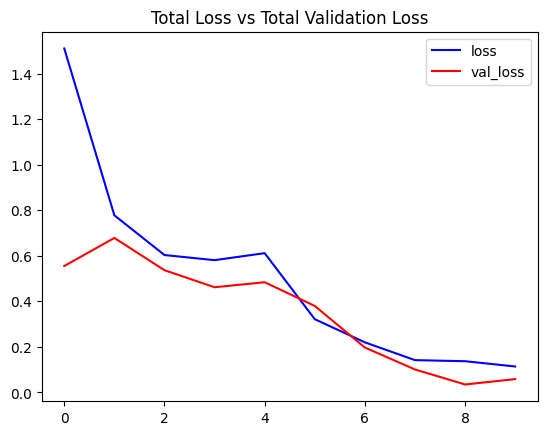

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

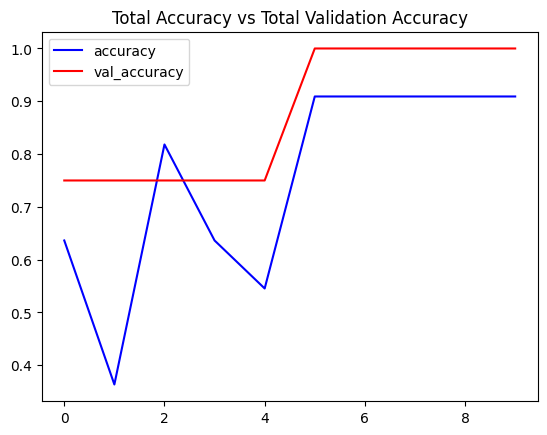

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')